# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></div><div class="lev1 toc-item"><a href="#Word-Segmentation" data-toc-modified-id="Word-Segmentation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Word Segmentation</a></div><div class="lev1 toc-item"><a href="#Tokenize-Text" data-toc-modified-id="Tokenize-Text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tokenize Text</a></div><div class="lev1 toc-item"><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word Embedding</a></div><div class="lev2 toc-item"><a href="#Read-Pretrained-Model" data-toc-modified-id="Read-Pretrained-Model-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Read Pretrained Model</a></div><div class="lev2 toc-item"><a href="#Use-Word2vec-to-Initialize-Embedding-Matrix" data-toc-modified-id="Use-Word2vec-to-Initialize-Embedding-Matrix-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Use Word2vec to Initialize Embedding Matrix</a></div><div class="lev1 toc-item"><a href="#Build-Dateset" data-toc-modified-id="Build-Dateset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Dateset</a></div><div class="lev1 toc-item"><a href="#Save-Dataset" data-toc-modified-id="Save-Dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save Dataset</a></div><div class="lev1 toc-item"><a href="#Checkpoint" data-toc-modified-id="Checkpoint-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Checkpoint</a></div><div class="lev1 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build Model</a></div><div class="lev2 toc-item"><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-81"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Import Libraries</a></div><div class="lev2 toc-item"><a href="#Model-Visualization" data-toc-modified-id="Model-Visualization-82"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Model Visualization</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-83"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Train</a></div><div class="lev2 toc-item"><a href="#Plot-Results" data-toc-modified-id="Plot-Results-84"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Plot Results</a></div><div class="lev1 toc-item"><a href="#Evaluate" data-toc-modified-id="Evaluate-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Evaluate</a></div>

# Load Data

In [1]:
import json
import os

In [2]:
def load_data(path, name):
    """
    Load date from file
    """
    data = []
    input_file = os.path.join(path)
    with open(input_file) as f:
        lines = f.readlines()
    for line in lines:
        item = json.loads(line)
        data.append(item[name])
    return data

In [3]:
sentence = load_data('/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/data/version_2/raw_data.json', 'abstract')

# Word Segmentation

In [4]:
import jieba
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
not_cuts = re.compile(u'([\da-zA-Z\.]+)')
re_replace = re.compile(u'([^\u4e00-\u9fa50-9a-zA-Z\%《》\(\)（）“”·\.])|（(.*?)）|\((.*?)\)')
stopWords = ['“', '”', '（', '）', '(', ')', '《', '》', '.', '%']

In [7]:
def newcut(s):
    """
    Word Segmentation
    """
    result = []
    j = 0
    s = re_replace.sub('', s)
    
    for i in not_cuts.finditer(s):
        result.extend(jieba.lcut(s[j:i.start()], HMM=False))
        result.append(s[i.start():i.end()])
        j = i.end()
    result.extend(jieba.lcut(s[j:], HMM=False))
    return result

def del_stop(ws):
    """
    Delete stopwords
    """
    return [i for i in ws if i not in stopWords]

In [8]:
sentWords = [del_stop(newcut(s)) for s in sentence]

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/kz/hqjl_dfx3g3_2vxylxlj1s940000gn/T/jieba.cache
Loading model cost 0.961 seconds.
Prefix dict has been built succesfully.


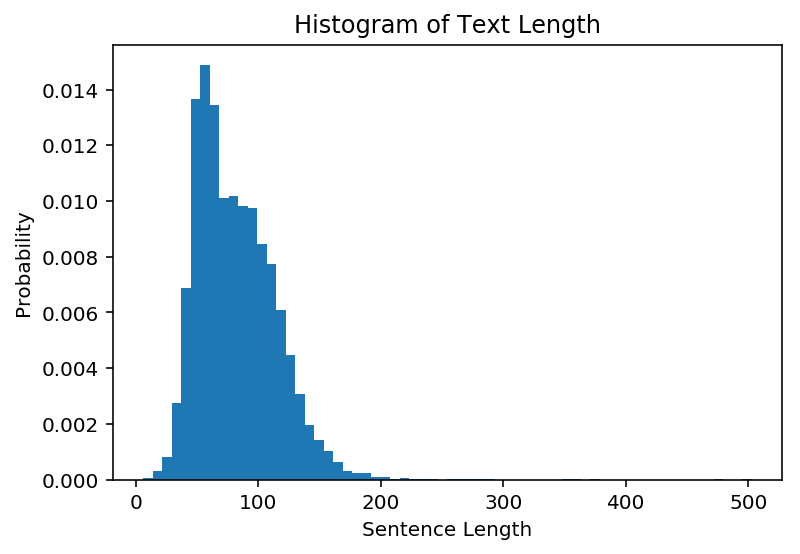

In [12]:
plt.hist([len(i) for i in sentWords], bins=64, normed=True);
plt.xlabel('Sentence Length')
plt.ylabel('Probability')
plt.title('Histogram of Text Length')  

# Tokenize Text

In [13]:
from keras.preprocessing.text import Tokenizer
import numpy as np

Using TensorFlow backend.


In [14]:
tokWords = sentWords.copy()
tokTexts = [' '.join(i) for i in tokWords]
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(tokTexts)
word2index = tokenizer.word_index
index2word = {i: w for w, i in word2index.items()}
sentLens = np.array([len(i) for i in sentWords])
print('Number of sentences: \t{:d}'.format(len(sentLens)))
print('Distribution of sentence lengths (number of words):')
print('Min: {:d}   Max: {:d}   Mean: {:.3f}   Med: {:.3f}'.format(np.min(sentLens), np.max(sentLens), np.mean(sentLens), np.median(sentLens)))
print('Found %s unique tokens.' % len(word2index))

Number of sentences: 	21273
Distribution of sentence lengths (number of words):
Min: 6   Max: 503   Mean: 81.775   Med: 77.000
Found 58192 unique tokens.


In [34]:
MAX_LEN = 160 # Approximately twice the median length of sentences

# Word Embedding

In [35]:
VOCAB_SIZE = len(index2word)+1
EMBEDDING_SIZE = 256
SEED = 42

## Read Pretrained Model

In [17]:
import gensim

In [20]:
word2vec = gensim.models.Word2Vec.load('/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/word2vec/version_1/word2vec')
word2vec.init_sims(replace=True)
w2v_embedding_weights = word2vec.wv.syn0
w2v_embedding_weights.std()

0.062496372

## Use Word2vec to Initialize Embedding Matrix 

In [21]:
# Generate random embedding with same scale as glove
np.random.seed(SEED)
shape = (VOCAB_SIZE, EMBEDDING_SIZE)
scale = w2v_embedding_weights.std() * np.sqrt(12) / 2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

In [22]:
count = 0
w2v_dict = word2vec.wv.index2word
for i in range(1, VOCAB_SIZE):
    w = index2word[i]
    if w in w2v_dict:
        g = word2vec[w]
        embedding[i, :] = g
        count += 1
print('{num_tokens}-{per:.3f}% tokens in vocab found in word2vec and copied to embedding.'.format(num_tokens=count, per=count/float(VOCAB_SIZE)*100))

35760-61.451% tokens in vocab found in word2vec and copied to embedding.


# Build Dateset

In [36]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [37]:
def convert_seq(ws):
    """
    Pad words sequene to MAX_LEN 
    """
    sentText = [' '.join(i) for i in ws]
    sentSeq = tokenizer.texts_to_sequences(sentText)
    sentData = pad_sequences(sentSeq, maxlen=MAX_LEN, padding='post', truncating='post')
    return sentData

In [38]:
x = convert_seq(sentWords)

In [39]:
xTrain, xTest = train_test_split(x, test_size=0.2, random_state=SEED)

# Save Dataset

In [41]:
import h5py
import pickle

In [43]:
fh = h5py.File('/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/sent2vec/version_2/allData.h5', 'w')
fh['xTrain'] = xTrain
fh['xTest'] = xTest
fh['embedding'] = embedding
fh.close()

# Checkpoint

In [64]:
import h5py
import os

In [63]:
DATA_DIR = '/Users/lizhn7/Downloads/EXPERIMENT/finance_causal_relation_extraction/sent2vec/version_2'

In [65]:
with h5py.File(os.path.join(DATA_DIR, 'allData.h5'), 'r') as fh:
    xTrain = fh['xTrain'][:]
    xTest = fh['xTest'][:]
    embedding = fh['embedding'][:]

# Build Model

In [48]:
MAX_LEN = 160
VOCAB_SIZE = embedding.shape[0]
EMBEDDING_SIZE = 256
LATENT_SIZE = 512
NUM_EPOCHS = 64
BATCH_SIZE = 64
NUM_TRAIN_STEPS = len(xTrain) // BATCH_SIZE
NUM_TEST_STEPS = len(xTest) // BATCH_SIZE

## Import Libraries

In [52]:
from keras.layers import Input, Masking, Bidirectional, LSTM, RepeatVector
from keras.models import Model
import keras.backend as K
from keras.callbacks import*
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [58]:
K.clear_session()
inputs = Input(shape=(MAX_LEN, EMBEDDING_SIZE), name='INPUT') 
mask = Masking(mask_value=0., name='MASKING')(inputs)
encoded = Bidirectional(LSTM(LATENT_SIZE, return_sequences=False, implementation=0), merge_mode='sum', name='ENCODER_BiLSTM')(mask)
decoded = RepeatVector(MAX_LEN, name="REPEATER")(encoded)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, implementation=0), merge_mode='sum', name='DECODER_BiLSTM')(decoded)
autoencoder = Model(inputs, decoded)
autoencoder.compile(loss='mse', optimizer='sgd')

## Model Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 160, 256)          0         
_________________________________________________________________
MASKING (Masking)            (None, 160, 256)          0         
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
_________________________________________________________________
REPEATER (RepeatVector)      (None, 160, 512)          0         
_________________________________________________________________
DECODER_BiLSTM (Bidirectiona (None, 160, 256)          1574912   
Total params: 4,724,736
Trainable params: 4,724,736
Non-trainable params: 0
_________________________________________________________________


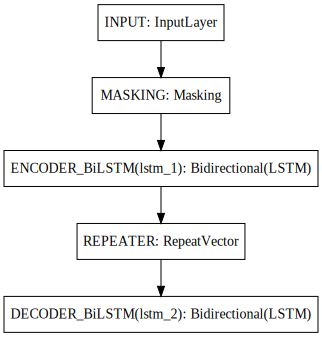

In [59]:
autoencoder.summary()
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

## Train

In [68]:
filepath = os.path.join(DATA_DIR, 'cp_logs/weights.{epoch:03d}-{val_loss:.6f}.hdf5')
log_string = os.path.join(DATA_DIR, 'tb_logs/s2v')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir=log_string) 

In [69]:
def sentence_generator(X, embeddings, batch_size):
    """
    Generate batches
    """
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size : (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [71]:
train_gen = sentence_generator(xTrain, embedding, BATCH_SIZE)
test_gen = sentence_generator(xTest, embedding, BATCH_SIZE)

In [ ]:
history = autoencoder.fit_generator(train_gen, 
                                    steps_per_epoch=NUM_TRAIN_STEPS,
                                    epochs=NUM_EPOCHS,
                                    #callbacks=[checkpoint, tensorboard],
                                    validation_data=test_gen,
                                    validation_steps=NUM_TEST_STEPS)

## Plot Results

In [ ]:
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.ylabel("loss (MSE)")
plt.xlabel("epochs")
plt.legend(loc="best")
plt.show()

# Evaluate

In [88]:
from tqdm import tqdm

In [73]:
def cosine_similarity(x, y):
    """
    Compute_cosine_similarity
    """
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [75]:
filename = os.path.join(DATA_DIR, 'cp_logs/weights.034-0.002746.hdf5')
autoencoder.load_weights(filename, by_name=True)

In [83]:
encoder = Model(autoencoder.input, autoencoder.get_layer('ENCODER_BiLSTM').output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           (None, 160, 256)          0         
_________________________________________________________________
MASKING (Masking)            (None, 160, 256)          0         
_________________________________________________________________
ENCODER_BiLSTM (Bidirectiona (None, 512)               3149824   
Total params: 3,149,824
Trainable params: 3,149,824
Non-trainable params: 0
_________________________________________________________________


In [89]:
# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in tqdm(range(NUM_TEST_STEPS)):
    xtest, ytest = next(test_gen)
    ytest_ = autoencoder.predict(xtest, verbose=0)
    Xvec = encoder.predict(xtest, verbose=0)
    Yvec = encoder.predict(ytest_, verbose=0)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

  2%|▏         | 1/66 [00:09<09:52,  9.12s/it]

0.607168376446
0.683617711067
0.632597565651
0.62266176939
0.647461354733
0.663487017155
0.623829126358
0.649053990841
0.654993534088
0.378256797791
0.645024418831


 11%|█         | 7/66 [01:03<08:59,  9.14s/it]

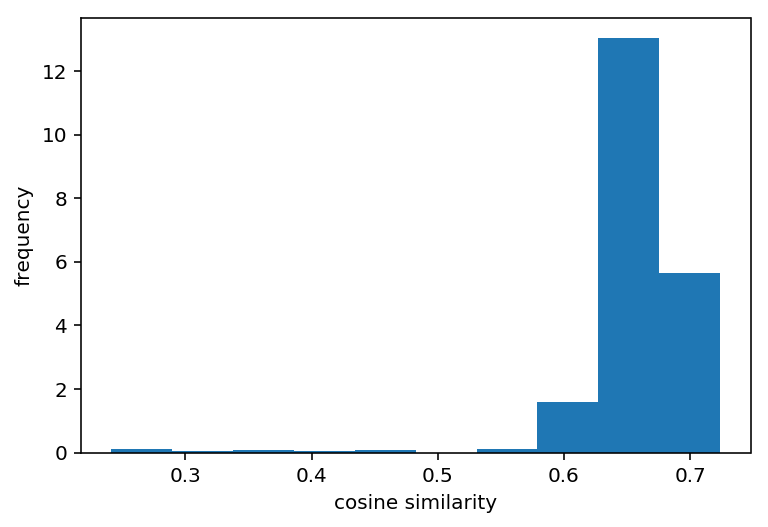

In [90]:
plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")